## PS8 
## Yangyang Dai

In [1]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

import sklearn
from sklearn.cross_validation import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.neural_network import MLPClassifier
from sklearn import svm
import warnings

/Users/yangyangdai/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
drink = pd.read_csv('strongdrink.txt')

In [3]:
drink.head()

,cultivar,alco,malic,ash,alk,magn,tot_phen,flav,nonfl_phen,proanth,color_int,hue,OD280rat,proline
0,1,14.23,1.71,2.43,15.6,127,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065
1,1,13.20,1.78,2.14,11.2,100,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050
2,1,13.16,2.36,2.67,18.6,101,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185
3,1,14.37,1.95,2.50,16.8,113,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480
4,1,13.24,2.59,2.87,21.0,118,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735


#### 1a  : Plot a scatterplot of the data

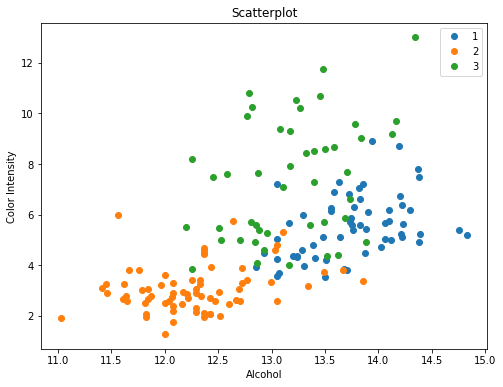

In [4]:
groups = drink.groupby('cultivar')

fig, ax = plt.subplots(figsize=(8,6))
for name, group in groups:
    ax.plot(group['alco'], group['color_int'], marker='o', linestyle='', label=name)
ax.legend()
plt.xlabel('Alcohol')
plt.ylabel('Color Intensity')
plt.title('Scatterplot')
plt.show()

#### 1b: Uses sklearn to fit multinomial logit. Use k-fold cross validation to estimate MSE. Play with param values of penalty and C to get lowest possible k-fold MSE. Report the MSE and param results from this procedure.

In [5]:
X = drink[['alco', 'malic', 'tot_phen', 'color_int']].values
y = drink['cultivar'].values

In [6]:
k = 4
kf = KFold(n_splits=k, random_state=22, shuffle=True)
kf.get_n_splits(X)
MSE = np.zeros(k)
C = np.zeros(200)
MSE_C = np.zeros(200)

for c in range(200):
    k_ind = int(0)
    for train_index, test_index in kf.split(X):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        LogReg = LogisticRegression(multi_class='multinomial', fit_intercept = True,
                                    solver='newton-cg', C = (c/100 + 0.01))
        LogReg.fit(X_train, y_train)
        y_pred = LogReg.predict(X_test)
        error = y_test != y_pred
        MSE[k_ind] = error.mean()
        k_ind += 1
    C[c] = c/100 + 0.01
    MSE_C[c] =  MSE.mean()
MSE_logit = pd.DataFrame({'C':C, 'MSE':MSE_C})

In [7]:
df_new = MSE_logit.sort_values(['MSE'])
df_new.head(30)

,C,MSE
43,0.44,0.068182
44,0.45,0.068182
42,0.43,0.068182
41,0.42,0.068182
40,0.41,0.068182
39,0.40,0.068182
27,0.28,0.068182
28,0.29,0.068182
29,0.30,0.068182
30,0.31,0.068182


We can see from above that when C = 0.44, penalty is 'l2', lowest MSE = 0.068182.

#### 1c: Use sklearn to fit the model in part b using a Random Forest classifier with bootstrap = True, oob_score=True, and random_state=22. Use OOB cross-validation to get MSE. Play with param values of n_estimators, max_depth, min_sample_leaf. Report the MSE and param values from this procedure.

In [8]:
from sklearn.ensemble import RandomForestClassifier
MSE_loop = pd.DataFrame({"n_estimator" : np.zeros(5),
                         "min_sample_leaf" : np.zeros(5),
                         "max_depth" : np.zeros(5),
                         "MSE" : np.zeros(5)})
MSE_RF = MSE_loop[:0]

for ml in range(15):
    for md in range(15):
        for tree in range(5):
            RF = RandomForestClassifier(n_estimators = (tree * 50 + 50),
                                        min_samples_leaf = (ml * 5 + 5),
                                        max_depth = (md + 1), bootstrap=True, 
                                        oob_score=True, random_state=22)
            RF.fit(X, y)
            MSE_loop["n_estimator"][tree] = tree * 50 + 50
            MSE_loop["max_depth"][tree] = md + 1
            MSE_loop["min_sample_leaf"][tree] = ml * 5 + 5
            MSE_loop["MSE"][tree] = 1 - RF.oob_score_
        MSE_RF = pd.concat([MSE_RF, MSE_loop])

In [9]:
MSE_RF.index = range(len(MSE_RF))
MSE_RF.sort_values(['MSE']).head(30)

,MSE,max_depth,min_sample_leaf,n_estimator
96,0.068182,5.0,10.0,100.0
126,0.068182,11.0,10.0,100.0
116,0.068182,9.0,10.0,100.0
131,0.068182,12.0,10.0,100.0
111,0.068182,8.0,10.0,100.0
106,0.068182,7.0,10.0,100.0
121,0.068182,10.0,10.0,100.0
101,0.068182,6.0,10.0,100.0
136,0.068182,13.0,10.0,100.0
86,0.068182,3.0,10.0,100.0


When max_depth = 5, min_sample_leaf = 10 and n_estimator = 100, the random forest model get the lowest MSE of 0.068182.

#### 1d: Use sklearn to fit the model in part b using a SVM. Do k-folds with k=4 as in part b. Play with param values of C and gamma. Report the MSE and param values from this procedure.

In [10]:
k = 4
kf = KFold(n_splits=k, random_state=22, shuffle=True)
kf.get_n_splits(X)
MSE = np.zeros(k)
MSE_C = pd.DataFrame({"Cost" : np.zeros(80),
                      "Gamma" : np.zeros(80),
                      "MSE" : np.zeros(80)})
MSE_SVM = MSE_C[:0]

for g in range(80):
    for c in range(80):
        k_ind = int(0)
        for train_index, test_index in kf.split(X):
            X_train, X_test = X[train_index], X[test_index]
            y_train, y_test = y[train_index], y[test_index]
            svc = svm.SVC(kernel='rbf', gamma = (g/20 + 0.05),
                          C=c/20 + 0.05)
            svc.fit(X_train, y_train)
            y_pred = svc.predict(X_test)
            error = y_test != y_pred
            MSE[k_ind] = error.mean()
            k_ind += 1
        MSE_C['Cost'][c] = c/20 + 0.05
        MSE_C['Gamma'][c] = g/20 + 0.05
        MSE_C['MSE'][c] =  MSE.mean()
    MSE_SVM = pd.concat([MSE_SVM, MSE_C])

In [11]:
MSE_SVM.index = range(len(MSE_SVM))
MSE_SVM.sort_values(['MSE']).head(30)

,Cost,Gamma,MSE
2659,1.00,1.70,0.045455
2578,0.95,1.65,0.045455
2658,0.95,1.70,0.045455
224,3.25,0.15,0.051136
225,3.30,0.15,0.051136
226,3.35,0.15,0.051136
227,3.40,0.15,0.051136
228,3.45,0.15,0.051136
229,3.50,0.15,0.051136
218,2.95,0.15,0.051136


From above, we can see that when cost = 1, gamma = 1.7, the SVM model will get the lowest MSE of 0.045455.



#### 1e: Use sklearn to fit the model to MLPC. Repeat k-folds with k=4. Play with params hidden_layer_sizes, activation, and alpha. Report the MSE and param values from this procedure.

In [12]:
k = 4
kf = KFold(n_splits=k, random_state=22, shuffle=True)
kf.get_n_splits(X)
MSE = np.zeros(k)
activ = np.array(['identity', 'logistic', 'tanh', 'relu'])
MSE_al = pd.DataFrame({"activation" : np.zeros(20),
                       "hidden layer" : np.zeros(20),
                       "alpha" : np.zeros(20),
                       "MSE":np.zeros(20)})
MSE_mlp = MSE_al[:0]

for ac in range(4):
    for h in range(8):
        for al in range(20):
            k_ind = int(0)
            for train_index, test_index in kf.split(X):
                X_train, X_test = X[train_index], X[test_index]
                y_train, y_test = y[train_index], y[test_index]
                mlp = MLPClassifier(activation=activ[ac], solver='lbfgs',
                                    alpha=(al/20 + 0.05), random_state=25,
                                    hidden_layer_sizes = ((50 * (h + 1)),))
                mlp.fit(X_train, y_train)
                y_pred = mlp.predict(X_test)
                error = y_test != y_pred
                MSE[k_ind] = error.mean()
                k_ind += 1
            MSE_al['activation'][al] = activ[ac]
            MSE_al['hidden layer'][al] = 50 * (h + 1)
            MSE_al['alpha'][al] = al/20 + 0.05
            MSE_al['MSE'][al] =  MSE.mean()
        MSE_mlp = pd.concat([MSE_mlp, MSE_al])

/Users/yangyangdai/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/yangyangdai/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/yangyangdai/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/yangyangdai/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:27: SettingWithCopyWarning: 
A

In [13]:
MSE_mlp.index = range(len(MSE_mlp))
MSE_mlp.sort_values(['MSE']).head(30)

,MSE,activation,alpha,hidden layer
601,0.039773,relu,0.10,350.0
532,0.039773,relu,0.65,150.0
603,0.039773,relu,0.20,350.0
553,0.039773,relu,0.70,200.0
527,0.039773,relu,0.40,150.0
584,0.039773,relu,0.25,300.0
609,0.039773,relu,0.50,350.0
613,0.039773,relu,0.70,350.0
562,0.039773,relu,0.15,250.0
616,0.045455,relu,0.85,350.0


As shown above, when activation = 'relu', alpha = 0.65 and hidden_layer_sizes = 150, the MLP model has the lowest MSE of 0.034091.

#### 1f: Which of the above four models is the best predictor?

In [14]:
top_logit = np.array(MSE_logit.sort_values(['MSE']).head(5)['MSE'])
top_RF = np.array(MSE_RF.sort_values(['MSE']).head(5)['MSE'])
top_SVM = np.array(MSE_SVM.sort_values(['MSE']).head(5)['MSE'])
top_mlp = np.array(MSE_mlp.sort_values(['MSE']).head(5)['MSE'])
rank = ['1', '2', '3', '4', '5']

comparison = pd.DataFrame({'Logit':top_logit, 
                    'RF':top_RF,
                    'SVM':top_SVM,
                    'MLP':top_mlp,
                    'rank':rank})
comparison

,Logit,MLP,RF,SVM,rank
0,0.068182,0.039773,0.068182,0.045455,1
1,0.068182,0.039773,0.068182,0.045455,2
2,0.068182,0.039773,0.068182,0.045455,3
3,0.068182,0.039773,0.068182,0.051136,4
4,0.068182,0.039773,0.068182,0.051136,5


The best model is MLP (activation = 'relu', alpha = 0.65 and hidden_layer_sizes = 150) with lowest MSE (0.034091).